<a href="https://colab.research.google.com/github/hfarruda/deeplearningtutorial/blob/master/deepLearning_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

This example is part of the [*Deep Learning Tutorial*](https://github.com/hfarruda/deeplearningtutorial), authored by Henrique F. de Arruda, Alexandre Benatti, César Comin, and Luciano da Fontoura Costa.

This example uses the Autoencoder model to illustrate a possible application concerning image clustering. Here we show how to use the resulting codes to reduce the dimensionality. We also project our data by using a Principal Component Analysis (PCA).

First of all, we import the necessary libraries. Here we opt for using Keras (using TensorFlow backend).

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import keras
from keras.models import Sequential, model_from_json, Model
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.datasets import fashion_mnist
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from keras.layers import UpSampling2D
from sklearn.preprocessing import MinMaxScaler
import sklearn.decomposition
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


If you have a GPU, you can use the following code to allocate processing into it.  Otherwise, proceed to (*).

In [0]:
import tensorflow as tf 
from keras import backend as K

print(K.tensorflow_backend._get_available_gpus())

number_of_cpu_cores = 8
config = tf.ConfigProto(device_count = {'GPU': 1 , 'CPU': number_of_cpu_cores}) 
session = tf.Session(config=config) 
keras.backend.set_session(session)

(*) In this example, we used the Fashion-MNIST database, composed by grayscale images of 10 fashion categories (trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot). It is available at Keras library on [keras-datasets](https://keras.io/datasets/).

In [0]:
(train_data, train_target), (test_data, test_target) = fashion_mnist.load_data()

train_target_one_hot_encoding = np_utils.to_categorical(train_target)

#Divide by the maximun value of a pixel (255) to have the values between 0 and 1
train_data = train_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

4423680/4422102 [==============================] - 2s 0us/step


For the sake of simplicity, we add zeros to the images to have shape 32x32. Because 32 is a power of 2 it is easier to configure the decoder layer.

In [0]:
train_data_auxiliar = []
for data in train_data:
    new_image = np.zeros((32,32))
    new_image[2:data.shape[0]+2, 2:data.shape[1]+2] = data
    train_data_auxiliar.append(new_image)

test_data_auxiliar = []
for data in test_data:
    new_image = np.zeros((32,32))
    new_image[2:data.shape[0]+2, 2:data.shape[1]+2] = data
    test_data_auxiliar.append(new_image)

train_data = np.array(train_data_auxiliar)
test_data = np.array(test_data_auxiliar)

train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 
                                train_data.shape[2], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1],
                              test_data.shape[2], 1)

In order to visualize a given figure, the following code can be executed.

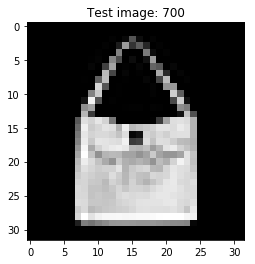

In [0]:
image_id = 700
image = test_data[image_id]
image = image[:,:,0]
plt.imshow(image, cmap = 'gray')
plt.title("Test image: " + str(image_id))
plt.show()

In the following, we define the network topology. As well as for the CNN, here we do not employ dropout after the convolutional layers. Because this network demands a high computational power, to test the code, the variable epochs can receive a smaller number (e.g., 5). However, in this case, the resultant accuracy tends to be much lower.

First we define some necessary variables.

In [0]:
input_shape = train_data.shape[1::]
#if len(input_shape) == 2:
#  input_shape = (input_shape[0], input_shape[1], 1)
filters_first_layer = 64
filters = 32
kernel_size = (3,3)
pool_size = (2,2)

activation = 'relu'
activation_function_output = 'sigmoid' #the output should be between 0 and 1
number_of_cnn_layers = 2
number_of_units_output = train_target_one_hot_encoding.shape[1]
padding = 'same'
strides = (2,2)

optimizer = 'adam'
loss = 'binary_crossentropy'
metrics = ['accuracy']
epochs = 50
batch_size = 128

#Network model
autoencoder_model = Sequential()

First we configure the encoder layers. Normally, for images the autoencoder is represented by a 2D matrix, but here we
adopt the flatten to be able to plot the respective PCA projection. 

In [0]:
autoencoder_model.add(Conv2D(filters = filters_first_layer,
                             kernel_size = kernel_size,
                             input_shape = input_shape, 
                             activation = activation, padding = padding ))

autoencoder_model.add(MaxPooling2D(pool_size = pool_size, padding = padding))


for i in range(number_of_cnn_layers-1):
    autoencoder_model.add(Conv2D(filters = filters, kernel_size = kernel_size, 
                                 activation = activation, padding = padding, 
                                 strides = strides))
    autoencoder_model.add(MaxPooling2D(pool_size = pool_size, 
                                       padding = padding))


#This is the coding
autoencoder_model.add(Flatten())
flatten_layer_name = autoencoder_model.output_names[0]

Here, we define the decoder.

In [0]:
#First we define the input size
output_len = autoencoder_model.output_shape[1]
height = np.int(np.sqrt(output_len/filters))

#Find the shape of the decoder input
autoencoder_model.add(Reshape((height, height, filters)))

for i in range(number_of_cnn_layers):
    autoencoder_model.add(Conv2D(filters = filters, kernel_size = kernel_size, 
                                 activation = activation, padding = padding))
    autoencoder_model.add(UpSampling2D(size = pool_size))

autoencoder_model.add(Conv2D(filters = filters_first_layer, 
                             kernel_size = kernel_size, 
                             activation = activation, padding = padding))
autoencoder_model.add(UpSampling2D(size = pool_size))
autoencoder_model.add(Conv2D(filters = 1, kernel_size = kernel_size, 
                             activation = activation_function_output, 
                             padding = padding))

We can use the following command to see the network topology.

In [0]:
autoencoder_model.summary()
#Saving the resultant figure as 'autoencoder_model.png'.
plot_model(autoencoder_model, to_file='autoencoder_model.png', show_shapes=True, 
           show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 32)          9248      
__________

The entire configuration is than used to train the coding and decoding.

In [0]:
autoencoder_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
autoencoder_model.fit(train_data, train_data, epochs = epochs, 
                      batch_size = batch_size)

W0828 11:44:07.276167 140106454980480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0828 11:44:07.316073 140106454980480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
60000/60000 [==============================] - 18s 293us/step - loss: 0.2507 - acc: 0.6194
Epoch 2/50
60000/60000 [==============================] - 12s 206us/step - loss: 0.2188 - acc: 0.6224
Epoch 3/50
60000/60000 [==============================] - 12s 206us/step - loss: 0.2137 - acc: 0.6231
Epoch 4/50
60000/60000 [==============================] - 12s 206us/step - loss: 0.2108 - acc: 0.6234
Epoch 5/50
60000/60000 [==============================] - 12s 207us/step - loss: 0.2087 - acc: 0.6236
Epoch 6/50
60000/60000 [==============================] - 12s 207us/step - loss: 0.2071 - acc: 0.6238
Epoch 7/50
60000/60000 [==============================] - 12s 206us/step - loss: 0.2059 - acc: 0.6239
Epoch 8/50
60000/60000 [==============================] - 12s 206us/step - loss: 0.2049 - acc: 0.6240
Epoch 9/50
60000/60000 [==============================] - 12s 206us/step - loss: 0.2040 - acc: 0.6241
Epoch 10/50
60000/60000 [==============================] - 12s 207us/step - loss: 

The following code shows how to use the already trained coding.

In [0]:
output_model = autoencoder_model.get_layer(flatten_layer_name).output
encoder = Model(inputs = autoencoder_model.input,
                outputs = output_model)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
Total params: 19,104
Trainable params: 19,104
Non-trainable params: 0
_________________________________________________________________


The following code is used to compute the codings.

In [0]:
codings = encoder.predict(test_data)

By employing the codings and the known classes, we plot a PCA (principal component analysis) of the test data.

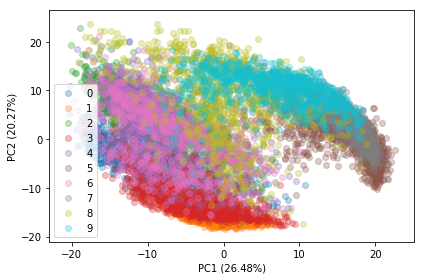

In [0]:
X = codings.copy()
targets = test_target

#Standardization
X = StandardScaler().fit_transform(X)
decomposition = sklearn.decomposition.PCA(n_components=2)
pca = decomposition.fit(X)
transform = pca.transform(X)

plt.figure(figsize = (6,4))
classes = []
for target in set(targets):
    classes.append(target)
    pos = np.argwhere(targets == target).T[0]
    plt.scatter([transform[pos,0]],[transform[pos,1]], alpha = 0.3)


label = "PC1 ({:1.2f}%)".format(pca.explained_variance_ratio_[0]*100)
plt.xlabel(label)
label = "PC2 ({:1.2f}%)".format(pca.explained_variance_ratio_[1]*100)
plt.ylabel(label)

plt.margins(0.05,0.05)
plt.legend(classes, loc = 'best')
plt.tight_layout()

plt.show()

## License

This Deep Learning Tutorial is licensed under a Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 (CC BY-NC-ND 4.0) International License.